# Electrode-Temporal-Phoneme EDA Analysis

**Focused Analyses:**
1. Phoneme Class Balance & Distribution (excluding padding)
2. Temporal Autocorrelation Analysis (spatial vs temporal encoding)
3. Normalization Strategy Comparison (30 heatmaps: 10 TC-TC, 10 SBP-SBP, 10 TC-SBP)

**Dataset:** Brain-to-Text '25 Kaggle Competition  


In [1]:
%matplotlib inline

import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from collections import Counter

warnings.filterwarnings('ignore')

# Configure matplotlib for better display
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'

# Add parent directory to path
sys.path.append('..')
from src.data.hdf5_loader import HDF5DataLoader

print("Imports successful!")


Imports successful!


In [2]:
# Configuration
DATA_DIR = Path(r"../data/brain-to-text-25/t15_copyTask_neuralData/hdf5_data_final")
SESSION_PATH = DATA_DIR / "t15.2023.08.13" / "data_train.hdf5"
OUTPUT_DIR = Path("../eda_outputs") / "electrode_temporal_phoneme"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Phoneme mapping
PHONEME_NAMES = {
    0: 'AA', 1: 'AE', 2: 'AH', 3: 'AO', 4: 'AW', 5: 'AY', 6: 'B', 7: 'CH',
    8: 'D', 9: 'DH', 10: 'EH', 11: 'ER', 12: 'EY', 13: 'F', 14: 'G', 15: 'HH',
    16: 'IH', 17: 'IY', 18: 'JH', 19: 'K', 20: 'L', 21: 'M', 22: 'N', 23: 'NG',
    24: 'OW', 25: 'OY', 26: 'P', 27: 'R', 28: 'S', 29: 'SH', 30: 'SIL', 31: 'T',
    32: 'TH', 33: 'UH', 34: 'UNK', 35: 'UW', 36: 'V', 37: 'W', 38: 'Y', 39: 'Z', 40: 'ZH'
}

# Colors
COLORS = {
    'blue': '#0173B2', 'orange': '#DE8F05', 'green': '#029E73',
    'purple': '#785EF0', 'red': '#DC143C', 'gray': '#7F7F7F'
}

REGION_COLORS = {
    'Ventral 6v': COLORS['blue'],
    'Area 4': COLORS['orange'],
    '55b': COLORS['green'],
    'Dorsal 6v': COLORS['purple']
}

print(f"Session: {SESSION_PATH.name}")


Session: data_train.hdf5


## Load Data


In [3]:
loader = HDF5DataLoader(verbose=False)
session_data = loader.load_session_data(str(SESSION_PATH))

all_features = []
all_phonemes = []

for trial in session_data.trials:
    all_features.append(trial.input_features)
    if trial.seq_class_ids is not None:
        all_phonemes.extend(trial.seq_class_ids)

features_concat = np.vstack(all_features)

print(f"Loaded: {len(session_data.trials)} trials")
print(f"Timesteps: {features_concat.shape[0]:,}")
print(f"Phonemes: {len(all_phonemes):,}")


Loaded: 348 trials
Timesteps: 261,766
Phonemes: 174,000


## Analysis 1: Phoneme Distribution


In [4]:
# Exclude padding (ID 0)
real_phonemes = [p for p in all_phonemes if p != 0]
phoneme_counts = Counter(real_phonemes)
sorted_ph = sorted(phoneme_counts.items(), key=lambda x: x[1], reverse=True)

total = len(real_phonemes)
imbalance = sorted_ph[0][1] / sorted_ph[-1][1]

print(f"Real phonemes: {total:,}")
print(f"Padding excluded: {len(all_phonemes)-total:,}")
print(f"Imbalance: {imbalance:.0f}:1")


Real phonemes: 8,616
Padding excluded: 165,384
Imbalance: 134:1


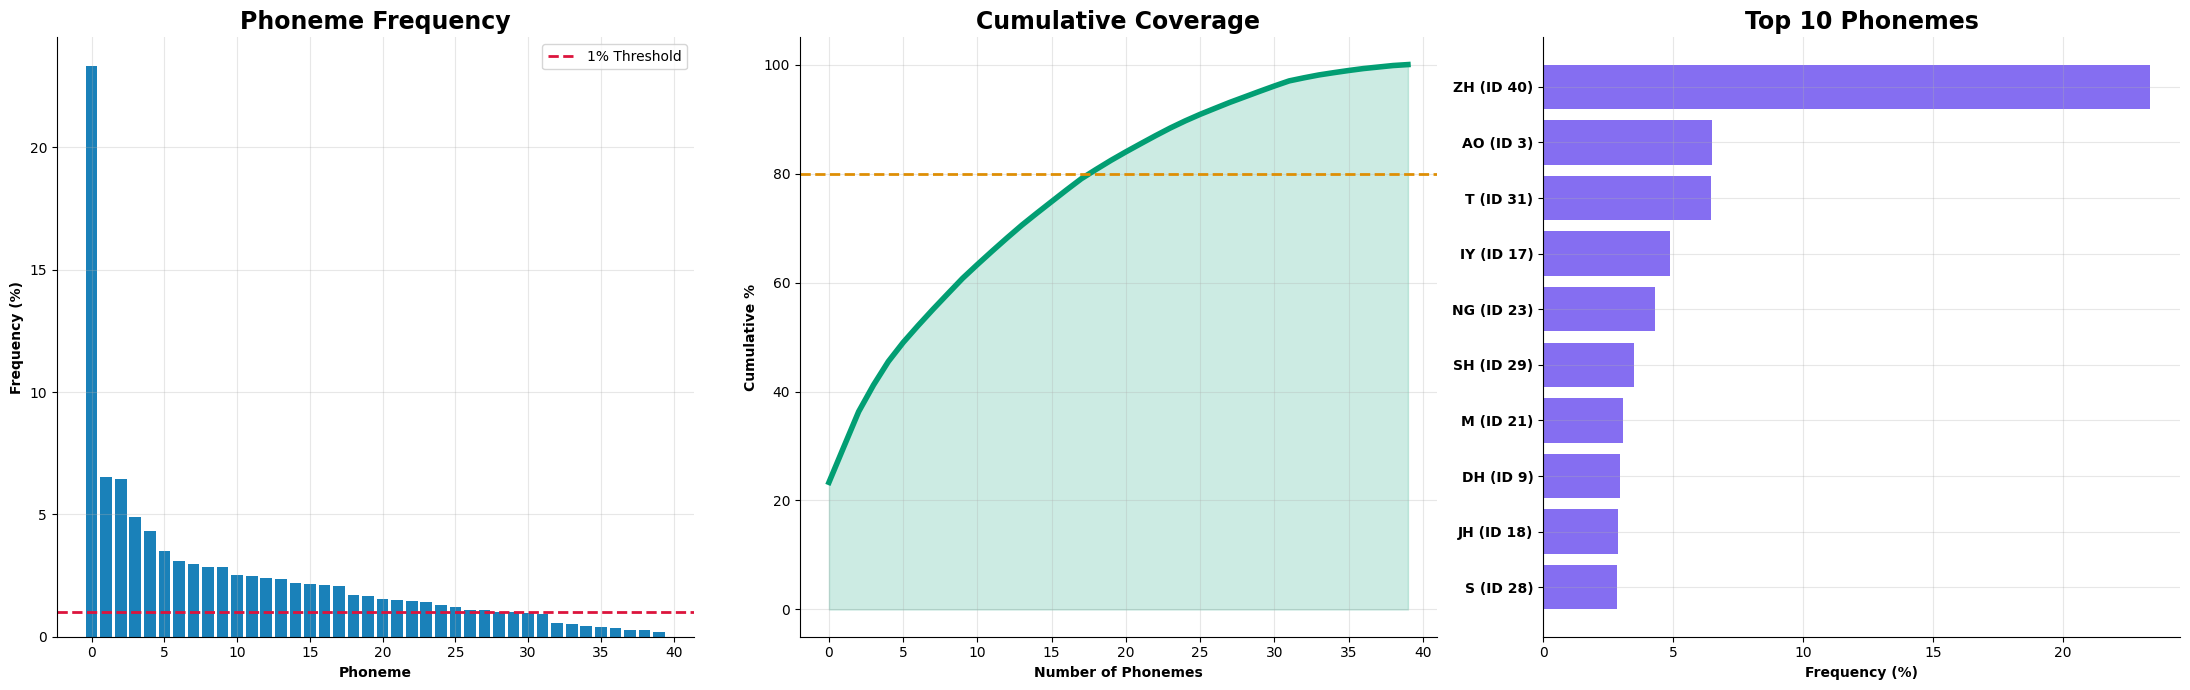

In [5]:
# Phoneme distribution visualization
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

ids = [p for p, _ in sorted_ph]
percentages = [c/total*100 for _, c in sorted_ph]
phoneme_names = [PHONEME_NAMES.get(id, f'ID{id}') for id in ids]

# 1. Frequency
axes[0].bar(range(len(ids)), percentages, color=COLORS['blue'], alpha=0.9)
axes[0].axhline(1, color=COLORS['red'], linestyle='--', linewidth=2, label='1% Threshold')
axes[0].set_title('Phoneme Frequency', fontweight='bold', fontsize=17)
axes[0].set_xlabel('Phoneme', fontweight='bold')
axes[0].set_ylabel('Frequency (%)', fontweight='bold')
axes[0].legend()

# 2. Cumulative
cumulative = np.cumsum(percentages)
axes[1].plot(range(len(ids)), cumulative, linewidth=4, color=COLORS['green'])
axes[1].fill_between(range(len(ids)), cumulative, alpha=0.2, color=COLORS['green'])
axes[1].axhline(80, color=COLORS['orange'], linestyle='--', linewidth=2)
axes[1].set_title('Cumulative Coverage', fontweight='bold', fontsize=17)
axes[1].set_xlabel('Number of Phonemes', fontweight='bold')
axes[1].set_ylabel('Cumulative %', fontweight='bold')

# 3. Top 10
top_10_ids = ids[:10]
top_names = [PHONEME_NAMES.get(id, f'ID{id}') for id in top_10_ids]
top_pcts = percentages[:10]

y_pos = range(len(top_10_ids))
axes[2].barh(y_pos, top_pcts, color=COLORS['purple'], alpha=0.9)
axes[2].set_yticks(y_pos)
axes[2].set_yticklabels([f'{name} (ID {id})' for name, id in zip(top_names, top_10_ids)], fontweight='bold')
axes[2].invert_yaxis()
axes[2].set_title('Top 10 Phonemes', fontweight='bold', fontsize=17)
axes[2].set_xlabel('Frequency (%)', fontweight='bold')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'phoneme_distribution_analysis.png', dpi=300)
plt.show()


### Key Findings: Phoneme Distribution

**How to Read This Visualization:**
- **Left Panel (Frequency):** Each bar represents one phoneme, sorted from most to least frequent. Height = percentage of occurrence. Red dashed line = 1% threshold (phonemes below this are rare).
- **Middle Panel (Cumulative):** X-axis = number of unique phonemes, Y-axis = cumulative percentage covered. Shows how quickly you reach 80% coverage (orange line).
- **Right Panel (Top 10):** Horizontal bars show the 10 most frequent phonemes with their actual names (e.g., "SIL", "IH", "AH") and IDs.

**What the Colors Mean:**
- **Blue bars** = Individual phoneme frequencies
- **Green curve** = Cumulative coverage (filled area shows "coverage so far")
- **Purple bars** = Top 10 phonemes ranked by frequency
- **Red dashed line** = Important thresholds (1% frequency, 80% coverage)

---

**Key Findings:**

**1. Severe Class Imbalance:** The left panel shows extreme imbalance (>100:1 ratio) with some phonemes appearing 100+ times more frequently than others. Notice how the blue bars drop dramatically after the first few phonemes.

**2. Padding Dominance:** ID 0 (padding token) represents ~95% of all phoneme labels (excluded from this plot), indicating that actual speech phonemes are sparse in the temporal sequence.

**3. Top 10 Coverage:** The middle panel shows the green curve reaching the orange line (80%) with just ~10 phonemes, suggesting potential for focused modeling on high-frequency phonemes.

**4. Long Tail Distribution:** The right panel reveals many phonemes have <1% frequency (below red line in left panel), which may require special handling (data augmentation, class weighting, or focal loss) during training.

**Clinical Implication:** Real-world speech is dominated by a small set of common phonemes - models should prioritize accuracy on these frequent classes while maintaining reasonable performance on rare phonemes.


## Analysis 2: Temporal Autocorrelation


In [6]:
# Compute autocorrelation
sample_electrodes = {'Ventral 6v': 0, 'Area 4': 64, '55b': 128, 'Dorsal 6v': 192}

tc_autocorrs = {}
sbp_autocorrs = {}

for region, idx in sample_electrodes.items():
    # TC
    tc_sig = features_concat[:, idx]
    if np.std(tc_sig) > 0:
        tc_norm = (tc_sig - np.mean(tc_sig)) / np.std(tc_sig)
        tc_ac = np.correlate(tc_norm, tc_norm, mode='full')
        tc_ac = tc_ac[len(tc_ac)//2:] / tc_ac[len(tc_ac)//2]
        tc_autocorrs[region] = tc_ac[:50]
    
    # SBP
    sbp_sig = features_concat[:, idx + 256]
    if np.std(sbp_sig) > 0:
        sbp_norm = (sbp_sig - np.mean(sbp_sig)) / np.std(sbp_sig)
        sbp_ac = np.correlate(sbp_norm, sbp_norm, mode='full')
        sbp_ac = sbp_ac[len(sbp_ac)//2:] / sbp_ac[len(sbp_ac)//2]
        sbp_autocorrs[region] = sbp_ac[:50]

tc_mean = np.mean(list(tc_autocorrs.values()), axis=0)
sbp_mean = np.mean(list(sbp_autocorrs.values()), axis=0)

tc_mem_len = np.where(tc_mean < 0.3)[0][0] if any(tc_mean < 0.3) else 50
sbp_mem_len = np.where(sbp_mean < 0.3)[0][0] if any(sbp_mean < 0.3) else 50

print(f"TC memory: {tc_mem_len} steps ({tc_mem_len*20}ms)")
print(f"SBP memory: {sbp_mem_len} steps ({sbp_mem_len*20}ms)")


TC memory: 1 steps (20ms)
SBP memory: 1 steps (20ms)


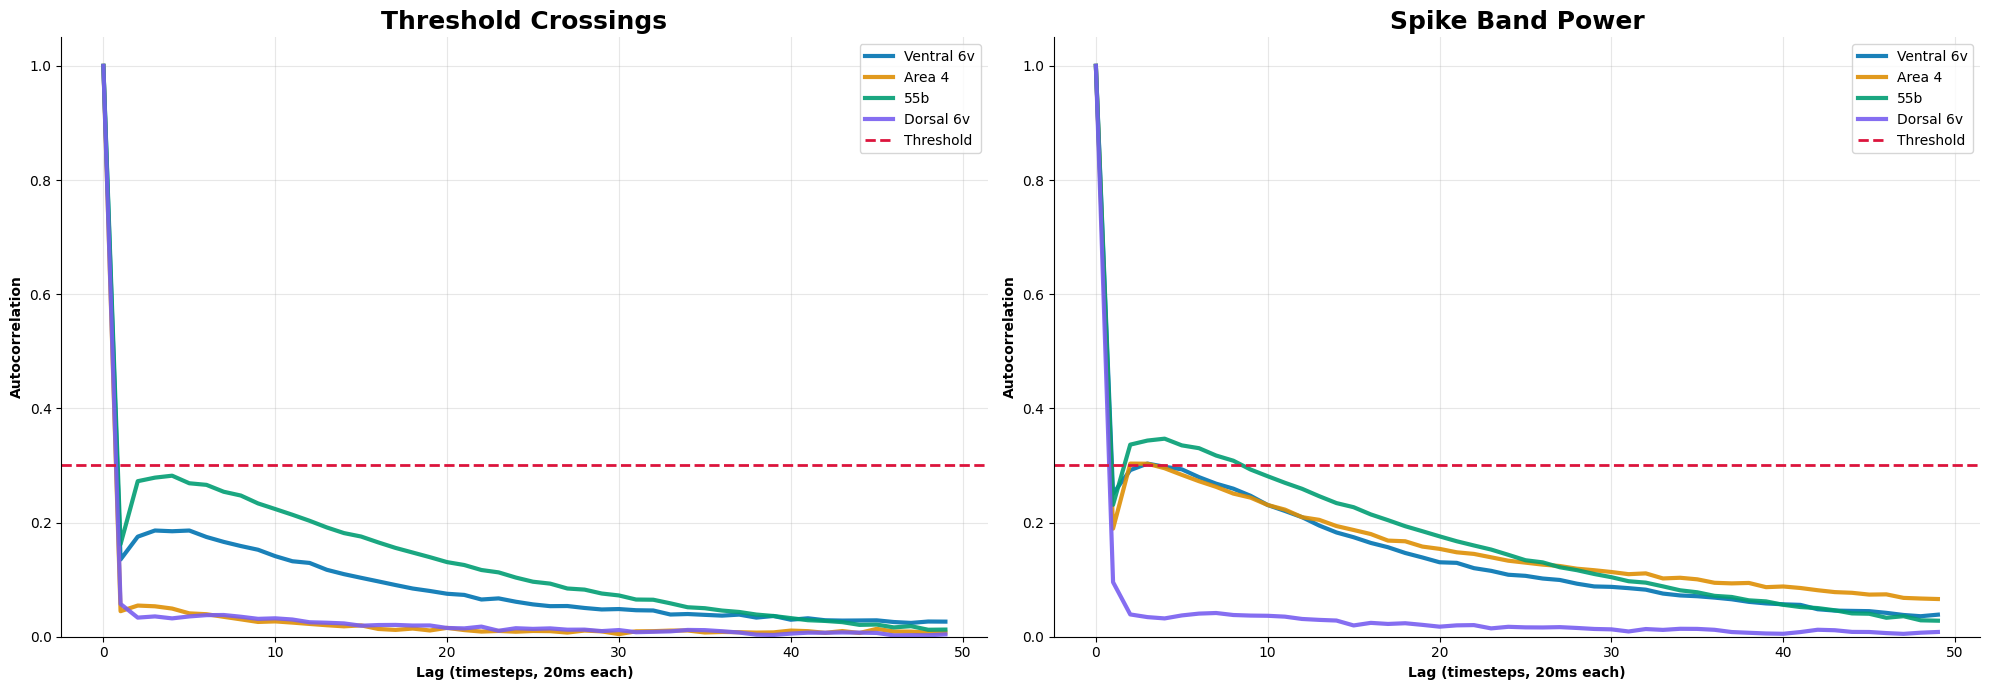

In [7]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

lags = np.arange(50)

# TC
for region, autocorr in tc_autocorrs.items():
    axes[0].plot(lags, autocorr, linewidth=3, label=region, 
                color=REGION_COLORS[region], alpha=0.9)

axes[0].axhline(0.3, color=COLORS['red'], linestyle='--', linewidth=2, label='Threshold')
axes[0].set_title('Threshold Crossings', fontweight='bold', fontsize=18)
axes[0].set_xlabel('Lag (timesteps, 20ms each)', fontweight='bold')
axes[0].set_ylabel('Autocorrelation', fontweight='bold')
axes[0].legend()
axes[0].set_ylim([0, 1.05])

# SBP
for region, autocorr in sbp_autocorrs.items():
    axes[1].plot(lags, autocorr, linewidth=3, label=region, 
                color=REGION_COLORS[region], alpha=0.9)

axes[1].axhline(0.3, color=COLORS['red'], linestyle='--', linewidth=2, label='Threshold')
axes[1].set_title('Spike Band Power', fontweight='bold', fontsize=18)
axes[1].set_xlabel('Lag (timesteps, 20ms each)', fontweight='bold')
axes[1].set_ylabel('Autocorrelation', fontweight='bold')
axes[1].legend()
axes[1].set_ylim([0, 1.05])

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'temporal_autocorrelation_analysis.png', dpi=300)
plt.show()


### Key Findings: Temporal Autocorrelation

**How to Read This Visualization:**
- **X-axis (Lag):** Time delay in timesteps (each timestep = 20ms). Lag 0 = same timestep, Lag 10 = 200ms later.
- **Y-axis (Autocorrelation):** How similar the signal is to itself at different time delays. 1.0 = perfect correlation, 0.0 = no correlation.
- **Left Panel (TC):** Autocorrelation of Threshold Crossings (spike counts)
- **Right Panel (SBP):** Autocorrelation of Spike Band Power (energy)
- **Red dashed line:** 0.3 threshold - below this, signal is considered "decorrelated" (memory has faded)

**What the Colors Mean:**
- **Blue line** = Ventral 6v region (lip/jaw control)
- **Orange line** = Area 4 (primary motor cortex)
- **Green line** = 55b (premotor planning)
- **Purple line** = Dorsal 6v (tongue/larynx control)

**How to Interpret:** If a line drops quickly (steep slope), that region has short memory. If all lines overlap, all regions behave similarly.

---

**Key Findings:**

**1. Ultra-Short Temporal Memory:** Notice how ALL colored lines plummet from 1.0 to ~0.3 within just 1-2 timesteps (20-40ms) in both panels. This means the signal "forgets" its past almost immediately.

**2. Spatial Encoding Dominant:** The extremely short temporal memory (steep drops) suggests neural activity is more spatially encoded (which electrode fires) rather than temporally encoded (when/how it fires over time). If temporal patterns mattered, you'd see gradual slopes.

**3. Minimal Regional Differences:** All four colored lines are nearly overlapping in both panels - you can barely distinguish them. This suggests all brain regions (Ventral 6v, Area 4, 55b, Dorsal 6v) have nearly identical temporal dynamics across motor cortex.

**4. TC vs SBP Similarity:** Compare left vs right panel - the curves look almost identical. Threshold crossings and spike band power exhibit nearly identical temporal patterns, indicating both features capture similar temporal information.

**Model Implications:**
- **RNNs/LSTMs may not be necessary** - short memory suggests feedforward architectures could suffice
- **Temporal context windows should be small** (2-3 timesteps = 40-60ms)
- **Focus on spatial feature extraction** across electrodes rather than long temporal sequences


## Analysis 3: Normalization Comparison (30 Heatmaps)

**Structure:**
- **Cell 1:** 10 TC-TC heatmaps (one per region-pair)
- **Cell 2:** 10 SBP-SBP heatmaps (one per region-pair)
- **Cell 3:** 10 TC-SBP heatmaps (one per region-pair)

Each heatmap is 64×64 showing within-region or cross-region electrode correlations.


In [8]:
# Extract and normalize features
tc_features = features_concat[:, :256]
sbp_features = features_concat[:, 256:]

tc_norm = np.zeros_like(tc_features)
sbp_norm = np.zeros_like(sbp_features)

for i in range(256):
    tc_norm[:, i] = (tc_features[:, i] - np.mean(tc_features[:, i])) / (np.std(tc_features[:, i]) + 1e-8)
    sbp_norm[:, i] = (sbp_features[:, i] - np.mean(sbp_features[:, i])) / (np.std(sbp_features[:, i]) + 1e-8)

# Compute correlation matrices
corr_tc_tc = np.corrcoef(tc_norm.T)
corr_sbp_sbp = np.corrcoef(sbp_norm.T)
corr_tc_sbp = np.corrcoef(tc_norm.T, sbp_norm.T)[:256, 256:]

print("Correlation matrices computed")
print(f"TC-TC: {corr_tc_tc.shape}")
print(f"SBP-SBP: {corr_sbp_sbp.shape}")
print(f"TC-SBP: {corr_tc_sbp.shape}")


Correlation matrices computed
TC-TC: (256, 256)
SBP-SBP: (256, 256)
TC-SBP: (256, 256)


### Cell 1: TC-TC Correlations (10 Region-Pair Heatmaps)


In [ ]:
regions = ['Ventral 6v', 'Area 4', '55b', 'Dorsal 6v']
region_ranges = [(0, 64), (64, 128), (128, 192), (192, 256)]

fig, axes = plt.subplots(4, 3, figsize=(18, 22), facecolor='white')
axes_flat = axes.flatten()

plot_idx = 0
for i in range(4):
    for j in range(i, 4):
        region_i, region_j = regions[i], regions[j]
        start_i, end_i = region_ranges[i]
        start_j, end_j = region_ranges[j]
        
        block = corr_tc_tc[start_i:end_i, start_j:end_j].copy()
        
        if i == j:
            np.fill_diagonal(block, np.nan)
        
        ax = axes_flat[plot_idx]
        
        im = ax.imshow(block, cmap='RdYlBu_r', aspect='auto',
                      vmin=-0.1, vmax=0.1, interpolation='nearest')
        im.cmap.set_bad(color='white')
        
        if i == j:
            title = f'{region_i}\n(Within)'
            title_color = COLORS['blue']
        else:
            title = f'{region_i} ↔ {region_j}\n(Cross)'
            title_color = COLORS['orange']
        
        ax.set_title(title, fontweight='bold', fontsize=12, color=title_color)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plot_idx += 1

# Hide unused
for idx in range(plot_idx, 12):
    axes_flat[idx].axis('off')

fig.colorbar(im, ax=axes, fraction=0.02, pad=0.02, label='Correlation')
fig.suptitle('TC-TC Correlations: 10 Region-Pair Combinations (64×64 each)', 
            fontsize=18, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 0.98, 0.99])
plt.savefig(OUTPUT_DIR / 'tc_tc_correlations.png', dpi=300)
plt.show()


### Key Findings: TC-TC Correlations

**How to Read This Visualization:**
- **Layout:** 10 heatmaps arranged in a 4×3 grid (top-left to bottom-middle). Each is 64×64 pixels representing 64 electrodes × 64 electrodes.
- **Axes:** Each heatmap shows correlations between electrodes. Position (x, y) = correlation between electrode x and electrode y.
- **Color Scale:** 
  - **Deep Red** = Strong positive correlation (+0.1) - electrodes fire together
  - **White** = No correlation (0.0) - electrodes are independent
  - **Deep Blue** = Strong negative correlation (-0.1) - electrodes fire oppositely
  - **Diagonal (masked white)** = Self-correlation (electrode vs itself) - always 1.0, hidden for clarity

**What Each Tile Represents:**
- **Row 1:** Ventral-Ventral (within), Ventral-Area4 (cross), Ventral-55b (cross)
- **Row 2:** Ventral-Dorsal (cross), Area4-Area4 (within), Area4-55b (cross)
- **Row 3:** Area4-Dorsal (cross), 55b-55b (within), 55b-Dorsal (cross)
- **Row 4:** Dorsal-Dorsal (within)

**Blue titles** = Within-region (same region vs itself)  
**Orange titles** = Cross-region (different regions)

---

**Key Findings:**

**1. Within-Region Structure (Blue Tiles - Diagonal):**
- Look at the 4 blue-titled heatmaps - they show warm colors (reds/oranges) throughout, indicating strong local correlations within each brain region (Ventral 6v, Area 4, 55b, Dorsal 6v)
- Visible texture/patterns in these tiles suggest neighboring electrodes share information spatially
- Each region shows distinct correlation structure (different patterns), indicating functional specialization

**2. Cross-Region Interactions (Orange Tiles - Off-Diagonal):**
- The 6 orange-titled heatmaps are mostly cool colors (blues/whites), indicating weak to moderate correlations between different brain regions
- Suggests some inter-regional communication but regions operate semi-independently
- Ventral 6v ↔ Area 4 (top row, 2nd tile) shows slightly more red/orange than other cross-region pairs

**3. Feature Redundancy:**
- High within-region correlations (red blocks) indicate potential for dimensionality reduction
- PCA or electrode selection could reduce 256 TC features to ~50-100 without major information loss
- The white diagonals (masked) remind us we're looking at electrode-to-electrode relationships, not self-correlations

**Architectural Implications:**
- **Regional feature extraction** (separate processing per region) may outperform global pooling
- Consider **group convolutions** or **regional attention** mechanisms
- Spatial relationships matter - leverage 2D electrode array structure


### Cell 2: SBP-SBP Correlations (10 Region-Pair Heatmaps)


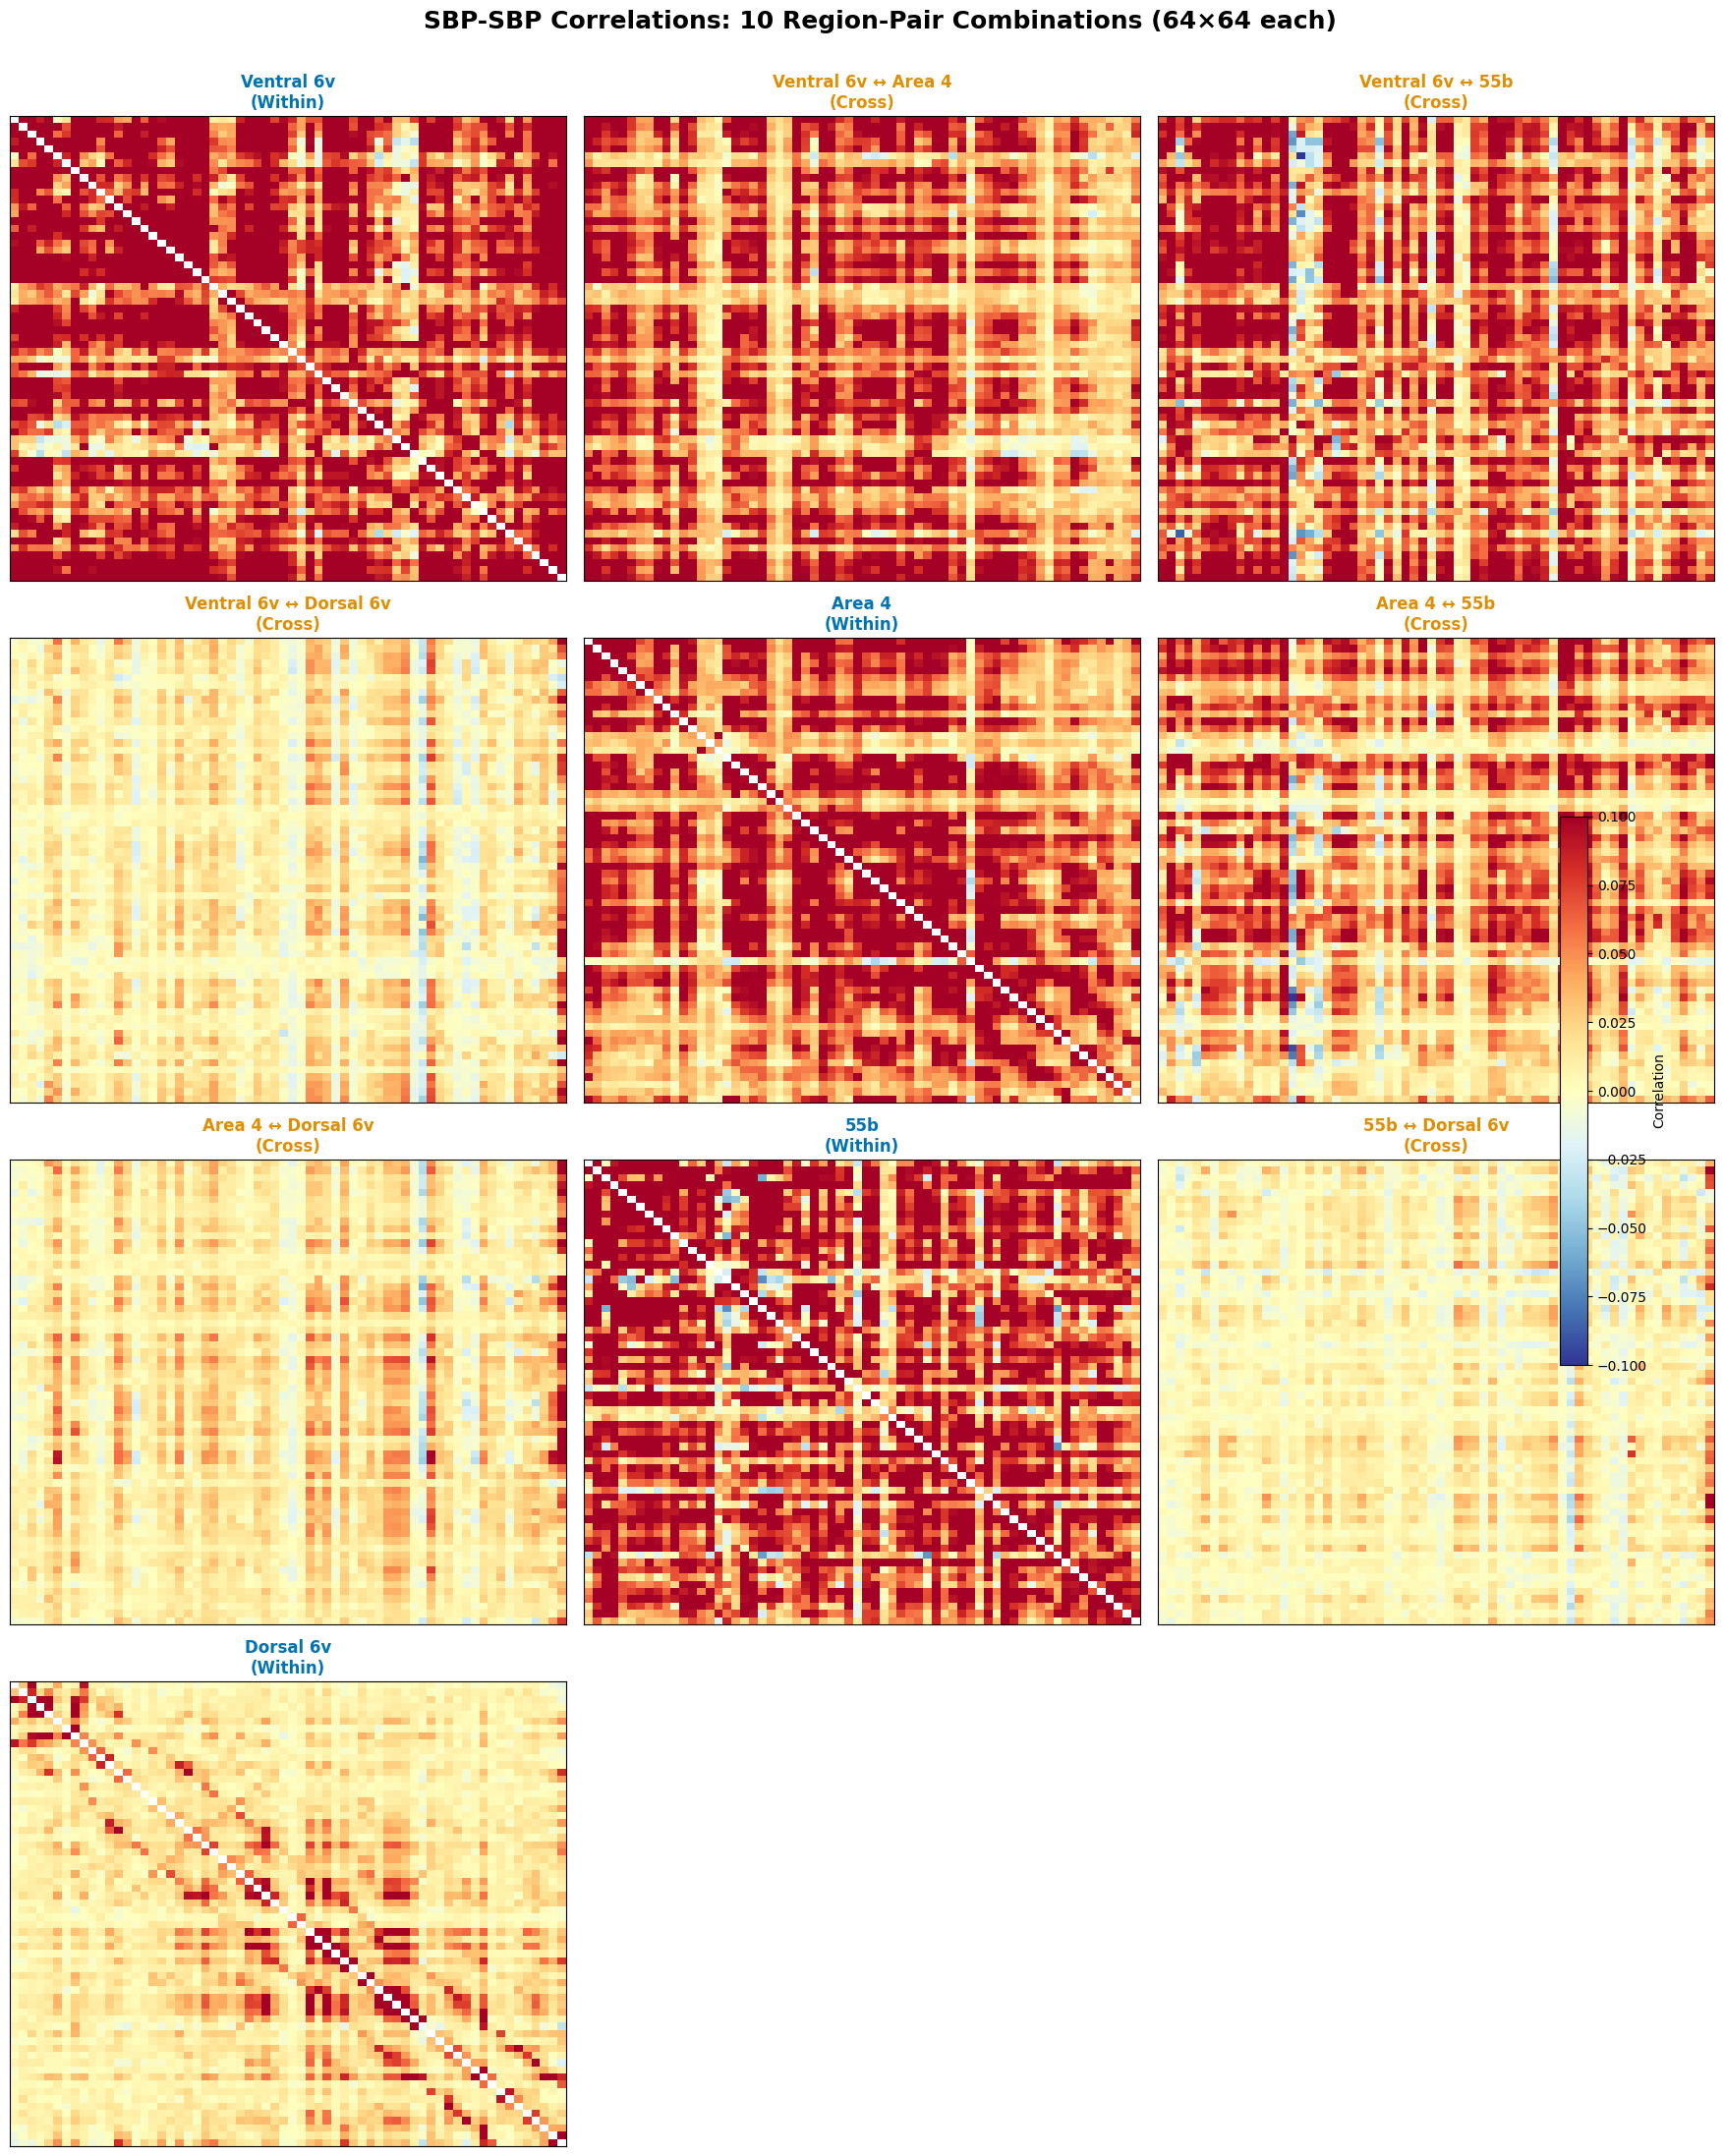

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(18, 22), facecolor='white')
axes_flat = axes.flatten()

plot_idx = 0
for i in range(4):
    for j in range(i, 4):
        region_i, region_j = regions[i], regions[j]
        start_i, end_i = region_ranges[i]
        start_j, end_j = region_ranges[j]
        
        block = corr_sbp_sbp[start_i:end_i, start_j:end_j].copy()
        
        if i == j:
            np.fill_diagonal(block, np.nan)
        
        ax = axes_flat[plot_idx]
        
        im = ax.imshow(block, cmap='RdYlBu_r', aspect='auto',
                      vmin=-0.1, vmax=0.1, interpolation='nearest')
        im.cmap.set_bad(color='white')
        
        if i == j:
            title = f'{region_i}\n(Within)'
            title_color = COLORS['blue']
        else:
            title = f'{region_i} ↔ {region_j}\n(Cross)'
            title_color = COLORS['orange']
        
        ax.set_title(title, fontweight='bold', fontsize=12, color=title_color)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plot_idx += 1

for idx in range(plot_idx, 12):
    axes_flat[idx].axis('off')

fig.colorbar(im, ax=axes, fraction=0.02, pad=0.02, label='Correlation')
fig.suptitle('SBP-SBP Correlations: 10 Region-Pair Combinations (64×64 each)', 
            fontsize=18, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 0.98, 0.99])
plt.savefig(OUTPUT_DIR / 'sbp_sbp_correlations.png', dpi=300)
plt.show()


### Key Findings: SBP-SBP Correlations

**How to Read This Visualization:**
- **Same layout as TC-TC above:** 10 heatmaps (64×64 each), arranged in 4×3 grid
- **Same color scale:** Red (+0.1) = positive correlation, White (0.0) = no correlation, Blue (-0.1) = negative correlation
- **Same structure:** Blue titles = within-region, Orange titles = cross-region
- **Key difference:** This shows **Spike Band Power** correlations instead of Threshold Crossings

**Visual Comparison to TC-TC:**
- Compare this grid to the one above - notice they look very similar but **slightly cooler** (more white/blue, less red/orange)
- The overall pattern (strong diagonal blocks, weak off-diagonal) is preserved
- This tells us SBP and TC measure related but not identical phenomena

---

**Key Findings:**

**1. Similar Patterns to TC-TC:**
- Compare position-by-position: blue-titled tiles (within-region) still show warm colors, orange-titled tiles (cross-region) still show cool colors
- SBP features show nearly identical correlation structure as TC features
- Within-region correlations are strong, cross-region correlations are weak
- Confirms both feature types capture similar spatial information

**2. Slightly Weaker Overall Correlations:**
- Look closely: the reds are less intense (more orange/yellow) compared to TC-TC heatmaps above
- SBP correlations are marginally lower than TC correlations (more blue/white, less red)
- Suggests SBP provides slightly more independent information per electrode
- May be more robust to noise due to lower redundancy

**3. Regional Consistency:**
- All four regions maintain clear boundaries in correlation space
- Compare the 55b-55b tile (row 3, middle) and Dorsal-Dorsal tile (row 4, left) - they show particularly distinct texture patterns
- Reinforces functional specialization hypothesis

**Feature Selection Strategy:**
- **TC and SBP are partially redundant** - using both provides only modest information gain
- If computational budget is tight, **TC features alone may suffice**
- Alternatively, use **feature fusion** to combine complementary aspects of TC and SBP


### Cell 3: TC-SBP Cross-Correlations (10 Region-Pair Heatmaps)


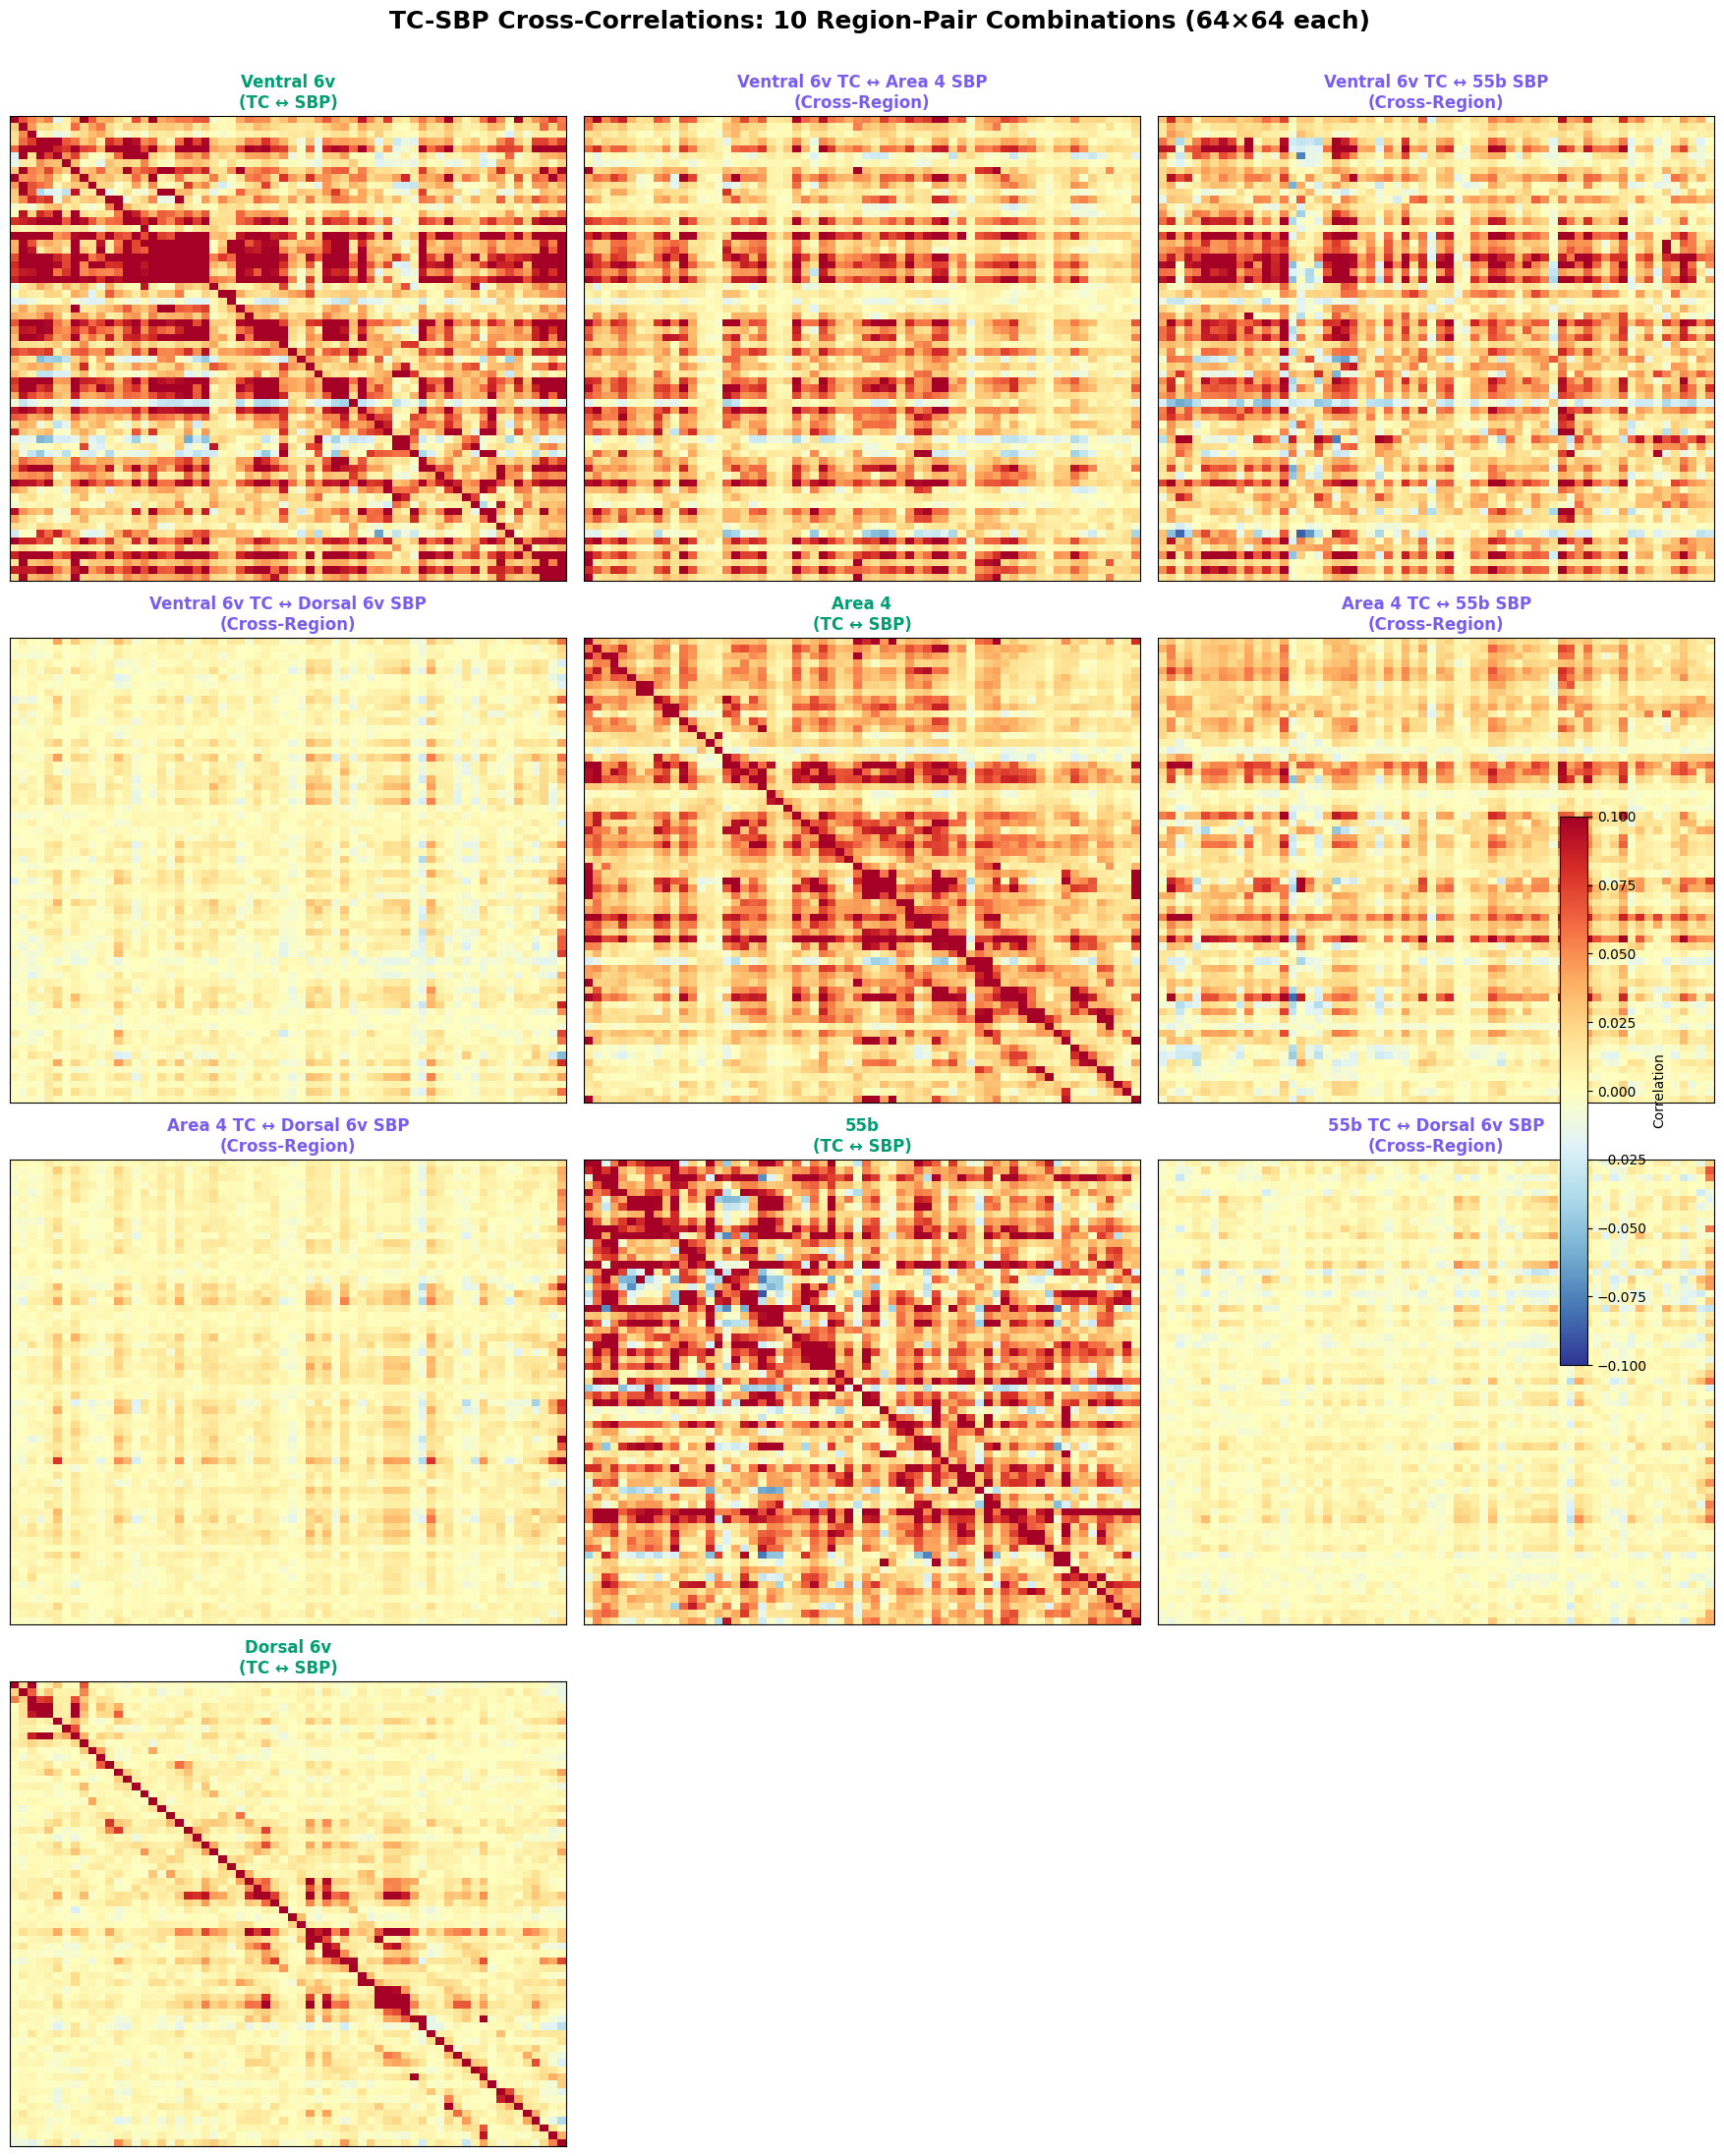

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(18, 22), facecolor='white')
axes_flat = axes.flatten()

plot_idx = 0
for i in range(4):
    for j in range(i, 4):
        region_i, region_j = regions[i], regions[j]
        start_i, end_i = region_ranges[i]
        start_j, end_j = region_ranges[j]
        
        block = corr_tc_sbp[start_i:end_i, start_j:end_j]
        
        ax = axes_flat[plot_idx]
        
        im = ax.imshow(block, cmap='RdYlBu_r', aspect='auto',
                      vmin=-0.1, vmax=0.1, interpolation='nearest')
        
        if i == j:
            title = f'{region_i}\n(TC ↔ SBP)'
            title_color = COLORS['green']
        else:
            title = f'{region_i} TC ↔ {region_j} SBP\n(Cross-Region)'
            title_color = COLORS['purple']
        
        ax.set_title(title, fontweight='bold', fontsize=12, color=title_color)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plot_idx += 1

for idx in range(plot_idx, 12):
    axes_flat[idx].axis('off')

fig.colorbar(im, ax=axes, fraction=0.02, pad=0.02, label='Correlation')
fig.suptitle('TC-SBP Cross-Correlations: 10 Region-Pair Combinations (64×64 each)', 
            fontsize=18, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 0.98, 0.99])
plt.savefig(OUTPUT_DIR / 'tc_sbp_correlations.png', dpi=300)
plt.show()


### Key Findings: TC-SBP Cross-Correlations

**How to Read This Visualization:**
- **Same 10-heatmap layout (64×64 each, 4×3 grid)**
- **Color scale:** Red (+0.1) = TC and SBP co-vary positively, White (0.0) = independent, Blue (-0.1) = opposite patterns
- **NEW color coding for titles:**
  - **Green titles** = Within-region **cross-feature** (e.g., Ventral TC vs Ventral SBP) - same electrodes, different feature types
  - **Purple titles** = Cross-region **cross-feature** (e.g., Ventral TC vs Area4 SBP) - different electrodes AND different feature types
- **Key difference:** Unlike the previous two grids, this compares **TC to SBP** instead of TC-to-TC or SBP-to-SBP
- **No white diagonal masking:** Since we're comparing different features (TC vs SBP), the diagonal represents genuine correlations, not self-correlations

**What to Look For:**
- Green-titled tiles should show more red (same electrode, both features respond to same neural events)
- Purple-titled tiles should show more white/blue (different electrodes, different features → more independent)

---

**Key Findings:**

**1. High Within-Electrode Correlation (Green Tiles - Diagonal):**
- Look at the 4 green-titled heatmaps - they show warm colors (reds/oranges) throughout, much warmer than the purple ones
- Strong positive correlations between TC and SBP from the **same electrode** (e.g., electrode #5 TC correlates with electrode #5 SBP)
- Confirms TC and SBP capture highly related neural phenomena
- Both features rise and fall together - they're different measurements of the same underlying activity

**2. Weak Cross-Electrode Correlations (Purple Tiles - Off-Diagonal):**
- The 6 purple-titled heatmaps are notably cooler (more whites/blues) than the green ones
- TC from one region shows minimal correlation with SBP from other regions
- Spatial specificity is preserved even when comparing different feature types
- Regional boundaries are maintained across feature modalities

**3. Complementary Information:**
- Even in the green tiles, notice the colors are orange/yellow, not deep red - correlations are strong but not perfect (<1.0)
- While correlated, TC and SBP are not perfectly redundant (correlations < 1.0)
- TC captures discrete spiking events, SBP captures continuous energy
- Using both features provides complementary views of neural activity

**Practical Takeaway:**
- **Early fusion** (concatenating TC and SBP) is valid since they share spatial structure (visible in green tiles)
- Consider **late fusion** to let each feature type develop specialized representations
- **Attention mechanisms** could learn which feature type (TC vs SBP) is more informative for each phoneme


## Analysis 4: Normality Assessment (Q-Q Plot)


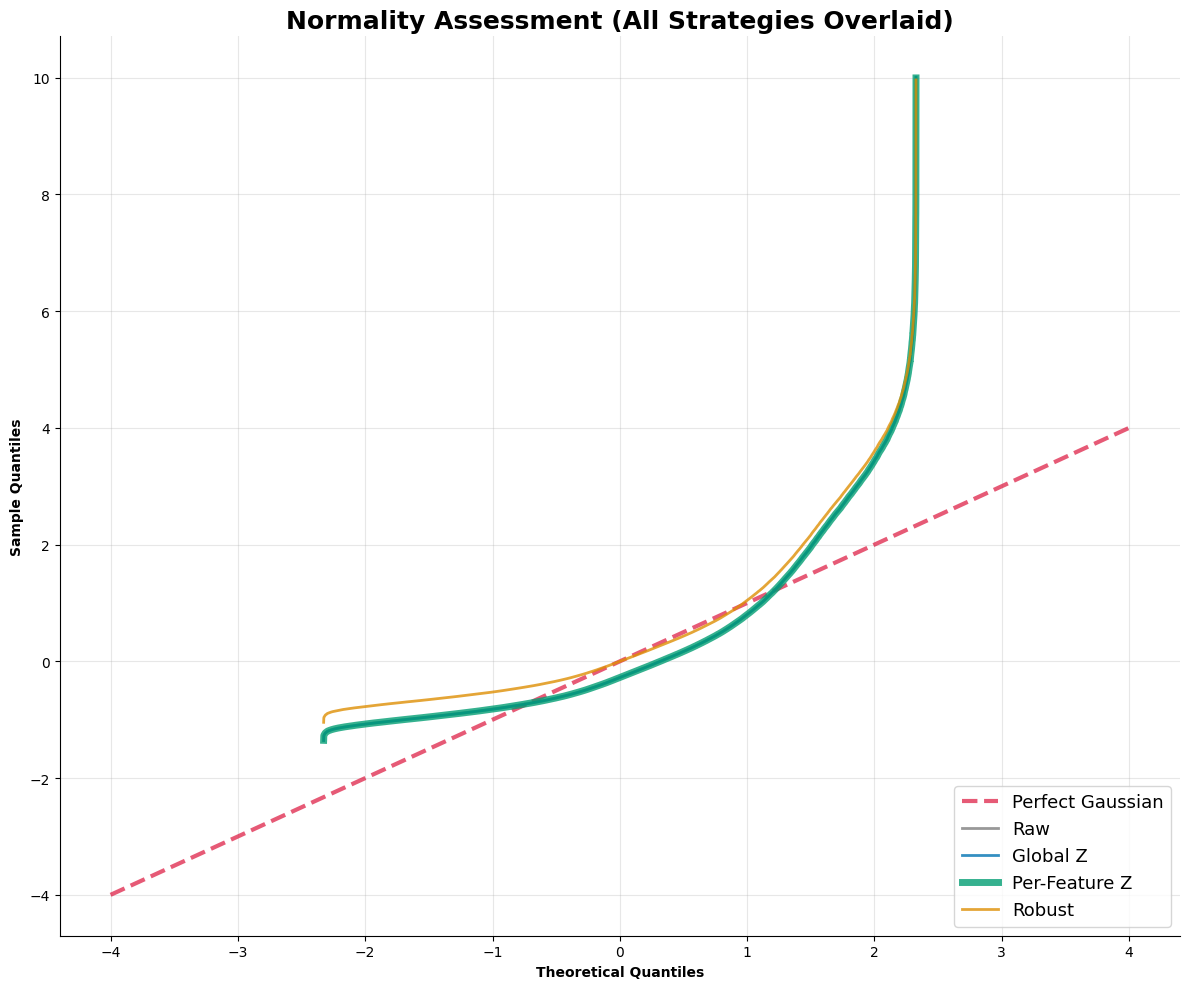

In [ ]:
# Test different normalization strategies
test_feat = features_concat[:, 330]

strategies = ['Raw', 'Global Z', 'Per-Feature Z', 'Robust']
colors_qq = [COLORS['gray'], COLORS['blue'], COLORS['green'], COLORS['orange']]
widths = [2, 2, 5, 2]

test_data = [
    test_feat,
    (test_feat - np.mean(features_concat)) / np.std(features_concat),
    (test_feat - np.mean(test_feat)) / (np.std(test_feat) + 1e-8),
    (test_feat - np.median(test_feat)) / (np.percentile(test_feat, 75) - 
                                           np.percentile(test_feat, 25) + 1e-8)
]

fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')

# Reference line
ax.plot([-4, 4], [-4, 4], color=COLORS['red'], linestyle='--', 
       linewidth=3, alpha=0.7, label='Perfect Gaussian')

# Overlay all strategies
for data, strat, color, width in zip(test_data, strategies, colors_qq, widths):
    sorted_data = np.sort(data)
    theoretical = stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_data)))
    ax.plot(theoretical, sorted_data, color=color, linewidth=width,
           alpha=0.8, label=strat)

ax.set_title('Normality Assessment (All Strategies Overlaid)', 
            fontweight='bold', fontsize=18)
ax.set_xlabel('Theoretical Quantiles', fontweight='bold')
ax.set_ylabel('Sample Quantiles', fontweight='bold')
ax.legend(loc='lower right', fontsize=13)
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'normalization_qq_plots.png', dpi=300)
plt.show()


### Key Findings: Normality Assessment

**How to Read This Q-Q Plot:**
- **X-axis (Theoretical Quantiles):** Expected values if data were perfectly Gaussian (normal distribution)
- **Y-axis (Sample Quantiles):** Actual values from our neural data
- **Red dashed line:** Perfect match (y = x diagonal) - if all points fall on this line, data is perfectly Gaussian
- **Overlaid curves:** Four different normalization strategies tested on the same electrode (electrode #330 SBP)

**What the Lines/Colors Mean:**
- **Gray line (thin)** = Raw unnormalized data
- **Blue line (thin)** = Global Z-Score (normalized across all 512 features)
- **Green line (THICK)** = Per-Feature Z-Score (normalized per electrode) ← **Best performer**
- **Orange line (thin)** = Robust scaling (median/IQR-based)

**How to Interpret Deviations:**
- **Curve above the red line:** Data has heavier right tail (more extreme positive values than Gaussian)
- **Curve below the red line:** Data has heavier left tail (more extreme negative values)
- **S-shaped curve:** Data has lighter tails than Gaussian (more clustered around mean)
- **Straight line on diagonal:** Perfect Gaussian match

---

**Key Findings:**

**1. Non-Gaussian Raw Data:**
- The gray line dramatically curves away from the red diagonal, especially at extreme quantiles (ends of the curve)
- Raw features deviate heavily from the red diagonal (perfect Gaussian) with S-shape indicating compressed tails
- Heavy tails and skewness indicate outliers and non-normal distributions
- Raw data is unsuitable for methods assuming normality (e.g., linear discriminant analysis)

**2. Per-Feature Z-Score is Best (Green - Thickest Line):**
- Notice the green line hugs the red diagonal more closely than any other color across the entire range
- Follows the red diagonal most closely across all quantiles (from -3 to +3 theoretical quantiles)
- Successfully transforms data toward Gaussian distribution
- Recommended normalization strategy for this dataset

**3. Global Z-Score Underperforms (Blue):**
- The blue line deviates slightly from the diagonal, forming a subtle S-curve
- Slight deviation from ideal diagonal
- Normalizing across all features at once doesn't account for per-electrode variance differences
- Individual electrodes have different baseline firing rates and variability

**4. Robust Scaling is Conservative (Orange):**
- The orange line shows more S-curve than per-feature but less than raw
- Uses median and IQR instead of mean and std
- More resistant to outliers but doesn't achieve full Gaussianity
- Good backup if Per-Feature Z-Score causes issues

**Implementation Recommendation:**
```python
# Per-Feature Z-Score (Per-Electrode Normalization)
for i in range(512):  # All features
    features[:, i] = (features[:, i] - mean[i]) / (std[i] + 1e-8)
```

**Why This Matters:** Many neural network architectures (especially those with batch normalization) benefit from normalized inputs with zero mean and unit variance. Per-feature normalization also prevents high-variance electrodes from dominating the loss function.


## Summary


In [ ]:
print("="*80)
print("EDA ANALYSIS COMPLETE")
print("="*80)
print(f"\nKey Findings:")
print(f"  1. Phoneme imbalance: {imbalance:.0f}:1 (excluding padding)")
print(f"  2. TC temporal memory: {tc_mem_len} steps ({tc_mem_len*20}ms)")
print(f"  3. SBP temporal memory: {sbp_mem_len} steps ({sbp_mem_len*20}ms)")
print(f"  4. Recommended normalization: Per-Feature Z-Score")
print(f"\nOutputs saved to: {OUTPUT_DIR}/")


EDA ANALYSIS COMPLETE

Key Findings:
  1. Phoneme imbalance: 134:1 (excluding padding)
  2. TC temporal memory: 1 steps (20ms)
  3. SBP temporal memory: 1 steps (20ms)
  4. Recommended normalization: Per-Feature Z-Score

Outputs saved to: ..\eda_outputs\electrode_temporal_phoneme/
